## Basic Scanner and Numbers Detector

First we go through all steps on one image. At the end the 'preprocessing'-function is introduced for all preprocessing steps which are applied to all images.
Discussion of what worked well and not will be at the end.

In [1]:
import numpy as np
import scipy
import skimage
import skimage.data
import skimage.io
import glob
import matplotlib.pyplot as plt
import skimage.feature
import skimage.transform as tf
import skimage.transform.hough_transform as ht
import cv2

In [2]:
#import all images from a folder to a list
image_list = []
factor = 0.25

for filename in glob.glob("data/*.jpg"): #assuming jpg
    im= skimage.io.imread(filename)
    im = skimage.color.rgb2gray(im)
    im = tf.rescale(im, scale=factor)
    image_list.append(im)
    

C:\Users\mumi\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
C:\Users\mumi\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\mumi\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


filtering of the image for edge detection

C:\Users\mumi\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


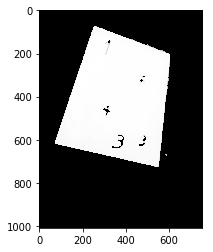

In [3]:
#this function is for filtering the image for better edge detection
#it works quite well, but fails when there is a lot of shadow on the paper
def mask_image(image):
    image = make_black_and_white(image)
    selem = skimage.morphology.square(11)
    image = skimage.filters.median(image, selem)
    return image

def make_black_and_white(image):
    mask2 = np.where((image<0.6),0,1).astype('uint8')
    return image*mask2[:,:]


#just plotting the new filtered image
index_image = 1
im = image_list[index_image]
im = mask_image(im)
plt.imshow(im, cmap="gray")
#plt.imshow(image_list[index_image], cmap="gray")

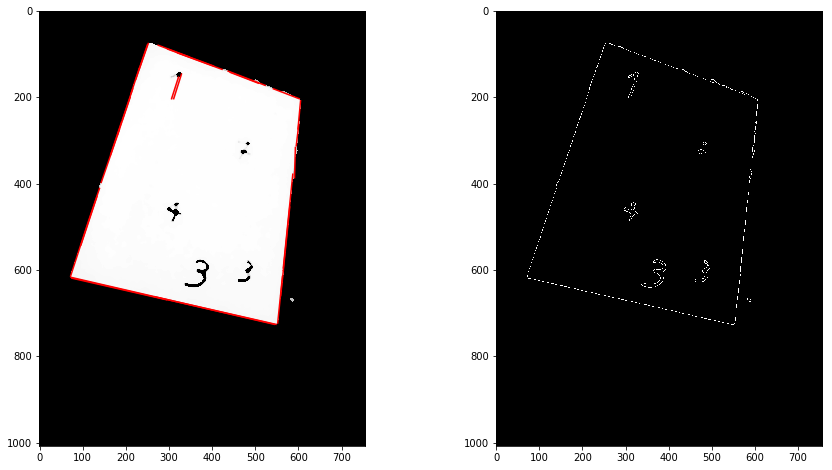

In [4]:
#In this function we detect the edges of the paper
def get_edges_image_and_hough(image):
    imedges = skimage.feature.canny(skimage.img_as_float(image),
                                    low_threshold=0.22,
                                    high_threshold=0.25,
                                    sigma=0.7)
    lines = ht.probabilistic_hough_line(imedges,
                                        threshold= 20)
    lines_dist = []
    for i in range(len(lines)):
        lines_dist.append(np.linalg.norm(np.asarray(lines[i])))
        
    return imedges, lines, lines_dist

#just for plotting the lines
imedges, lines, lines_dist = get_edges_image_and_hough(im)
fig,(ax0,ax1) = plt.subplots(ncols=2, figsize=(15,8))
ax0.imshow(im,cmap="gray")
for ((x0,y0),(x1,y1)) in lines:
    ax0.plot([x0,x1],[y0,y1],'r-')
ax1.imshow(imedges,cmap="gray")

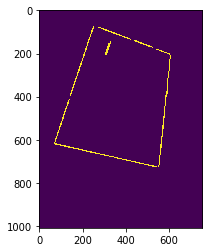

In [5]:
#The function function creates a new image with only the detected lines
def get_img_edges(image, lines):
    img_edg = np.zeros((image.shape[0], image.shape[1]))
    for line in lines:
        cv2.line(img_edg, line[0], line[1],(1,1,1),3)
    return img_edg

#just for plotting
img_edg = get_img_edges(im, lines)
plt.imshow(img_edg)

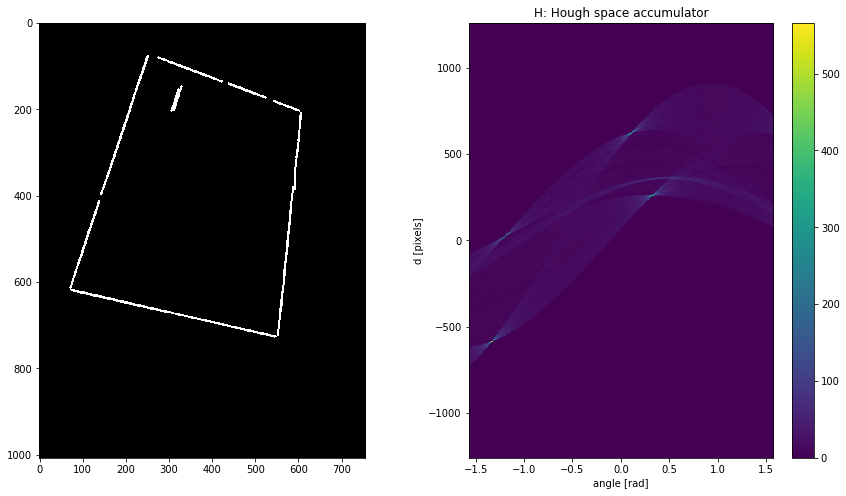

In [6]:
#With this function we get the hough parameters
def get_hough_lines(image_edges):
    H,angles,distances = ht.hough_line(image_edges)
    return H,angles,distances

H,angles,distances = get_hough_lines(img_edg)
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(img_edg, cmap="gray")
Himage = ax1.imshow(H,
                    extent=(angles[0],angles[-1],distances[0],distances[-1]),
                    origin="lower", aspect="auto")
ax1.set(xlabel="angle [rad]",
        ylabel="d [pixels]",
        title="H: Hough space accumulator");
plt.colorbar(Himage)

In [7]:
#calculates the intersection of two lines
def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False
#forms from two points a line
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C


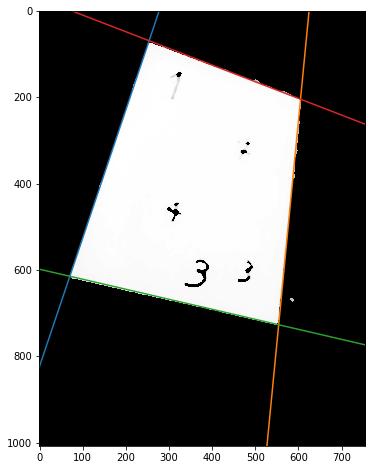

In [8]:
#We extract only the 4 strongest lines
def get_lines_of_paper(H, angles, distances):
    H1,angles1,distances1 = ht.hough_line_peaks(H,angles,distances,min_distance = 30, min_angle= 10, threshold = 80, num_peaks= 4)

    lines_final4 = []
    for i in range(len(angles1)):
        d= distances1[i]
        theta = angles1[i]   
        p1 = np.array([d*np.cos(theta), d*np.sin(theta)])
        linedir = np.array([np.cos(theta+np.pi/2), np.sin(theta+np.pi/2)])
        p0 = p1 - linedir * 1000
        p2 = p1 + linedir * 1000
        lines_final4.append(line(p0,p2))
    return lines_final4

#just for plotting
H1,angles1,distances1 = ht.hough_line_peaks(H,angles,distances,min_distance = 30, min_angle= 10, threshold = 80, num_peaks= 4)
lines_final4 = get_lines_of_paper(H, angles, distances)
#Show the lines
fig,ax0 = plt.subplots(ncols=1, nrows=1, figsize=(15,8))
ax0.imshow(im, cmap="gray")
for i in range(len(angles1)):
    d= distances1[i]
    theta = angles1[i]
## Now we want to draw the line in image space
# This is one point on the line
    p1 = np.array([d*np.cos(theta), d*np.sin(theta)])
# This is the unit vector pointing in the direction of the line (remember what theta means in Hough space!)
    linedir = np.array([np.cos(theta+np.pi/2), np.sin(theta+np.pi/2)])
# These are two points very far away in two opposite directions along the line
    p0 = p1 - linedir * 1000
    p2 = p1 + linedir * 1000
# We now draw a line through p0 and p2, without rescaling the axes.
    ax0.plot([p0[0],p2[0]],[p0[1],p2[1]], scalex=False, scaley=False)


In [9]:
#we calculate the 4 corners of the paper and match in the hopefully right order
#needs improvement
def get_corners_of_paper(image, lines_final4):
    edges = []
    c = 10000
    min_n = 4
    
    corner_image = [[0-c,im.shape[0]+c],[im.shape[1]+c,im.shape[0]+c],[im.shape[1]+c,-c],[-c,-c]]

    for i in range(3):
        for j in range((4-i-1)):
            edges.append(intersection(lines_final4[i],lines_final4[i+j+1]))

    middle = [im.shape[0]/2,im.shape[1]/2]
    dist_to_middle = []
    
    for edge in edges:
        dist_to_middle.append(np.linalg.norm(edge-np.asarray(middle)))

    idx = np.asarray(dist_to_middle).argsort()[:min_n]
    edges = [edges[i] for i in idx]
    #match edges to the right corner
    corner_paper = []
    for corner in corner_image:
        dist_corners = []
        for edge in edges:
            dist_corners.append(np.linalg.norm(np.asarray(corner)-np.asarray(edge)))
        i_x = np.asarray(dist_corners).argsort()[0]
        corner_paper.append(edges[i_x])
    return corner_paper

corner_paper = get_corners_of_paper(im, lines_final4)
print(corner_paper)


[(70.22565470943765, 614.5416721926923), (554.265121965782, 726.937428012679), (604.8891261673837, 204.12594902437917), (253.989776533835, 68.60328813986305)]


In [10]:
#distance for the right orientation and should bring it in long format 
#needs improvement, does not work every time.
def rotate_corners(corner_paper):
    dist_edges = []
    corner_paper_extend = corner_paper.copy()
    corner_paper_extend.append(corner_paper[0])
    for i in range(4):
        dist_edges.append(np.linalg.norm(np.asarray(corner_paper_extend[i])-np.asarray(corner_paper_extend[i+1])))
    if dist_edges[0]+dist_edges[2] > dist_edges[1]+dist_edges[3]: #to make sure that in high format and not wide
        corner_paper[0:2], corner_paper[3] = corner_paper[1:], corner_paper[0]
        corner_paper = corner_paper[:-1]
    return corner_paper
corner_paper = rotate_corners(corner_paper)

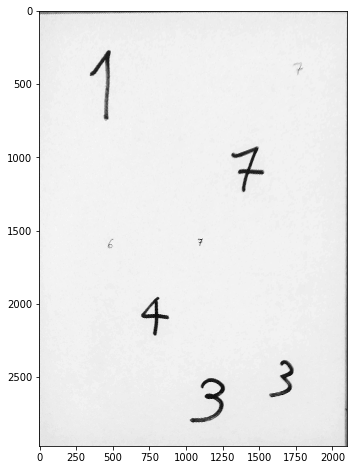

In [11]:
#for rotation of the original image

def transform_image(image, corners_paper):
    factor = 10
    src_corners = []
    corner_warped_image = [[0, 297], [210, 297], [210, 0], [0, 0]]
    for corner in corners_paper:
        src_corners.append(np.asarray(corner))

    dst = np.array(corner_warped_image)*factor
    src = np.array(src_corners)

    tf = skimage.transform.estimate_transform('projective',src,dst)
    invtf = tf.inverse
    tim = skimage.transform.warp(image=image, inverse_map=invtf, output_shape=(297*factor,210*factor), mode = 'edge')

    return tim
#just for plotting
tim = transform_image(image_list[index_image], corner_paper) # we use the original image for rotating.
fig = plt.subplots(figsize=(15,8))
plt.imshow(tim, cmap="gray")

<p style="color:red;">This section needs attention =)</p>

C:\Users\mumi\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


There are 5 large regions


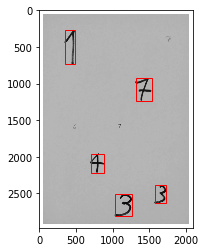

In [12]:
import matplotlib.patches as patches

import skimage.measure

#filter out the numbers from the paper. 
def filter_nrs_paper(filename, tim):
    
    #bias for border: room for improvement, see above with filtering
    bias = 50
    tim[0:bias,:] = 1
    tim[-bias:,:] = 1
    tim[:,0:bias] = 1
    tim[:,-bias:] = 1

    mask = tim < 0.5 # bright pixels will be True in the mask, others will be False 
    labels = skimage.measure.label(mask)

    regions = skimage.measure.regionprops(labels)
    large_regions = [r for r in regions if r.area > 50]
    
    mask = tim < 0.5
    
    labels = skimage.measure.label(mask)
    regions = skimage.measure.regionprops(labels)
    large_regions = [r for r in regions if r.area > 100]
    counter = 0
    image_indiv = []
    for r in large_regions:
        (min_row, min_col, max_row, max_col) = r.bbox
        file_name = "images/"+filename+str(counter).rjust(5, "0") + ".png"
        small_im = tim[min_row:max_row, min_col:max_col]
        image_indiv.append(small_im)
        skimage.io.imsave(file_name,tim[min_row:max_row, min_col:max_col])
        counter += 1
        
    return large_regions, image_indiv

#just for plotting
large_regions, image_small = filter_nrs_paper('nr_0', tim)
print(f"There are {len(large_regions)} large regions")

#str(counter).rjust(5, "0") 
fig, ax = plt.subplots()
ax.imshow(tim, cmap="gray")
for r in large_regions:
    (min_row, min_col, max_row, max_col) = r.bbox
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row),width,height,
                             linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

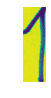

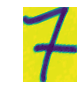

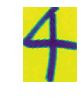

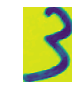

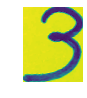

In [13]:
def showim(im, l=None, ax=None):
    if ax is None:
        fig,ax = plt.subplots()
    ax.imshow(im)
    ax.axis("off")
    if l is not None:
        ax.set_title(labelnames[l])
#lets check each number    
for i in range(len(image_small)):
    fig, ax = plt.subplots(figsize=(2, 2), dpi=50)
    showim(image_small[i],  ax=ax)
    plt.show()

In [14]:
# do above steps for an image
def preproc_im(image):
    counter = 0
    im = mask_image(image)
    imedges, lines, lines_dist = get_edges_image_and_hough(im)
    img_edg = get_img_edges(im, lines)
    H,angles,distances = get_hough_lines(img_edg)
    lines_final4 = get_lines_of_paper(H, angles, distances)
    corner_paper = get_corners_of_paper(im, lines_final4)
    corner_paper = rotate_corners(corner_paper)
    tim = transform_image(make_black_and_white(image), corner_paper)
    large_regions, image_small = filter_nrs_paper(str(counter).rjust(5, "0") , tim)
        
    return tim, image_small

tim, image_small = preproc_im(image_list[index_image])

### Lets construct the CNN to classifier each number

In [15]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [16]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_cols = 28
img_rows = 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

X_train =  X_train.astype('float32')                       #change the type towards float32
X_test =   X_test.astype('float32')                        #idem
X_train /= 255.0                                           #normalize the range to be between 0.0 and 1.0
X_test /=  255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [ ]:
n_classes = 10
batch_size = 128
epochs = 20
D = X_train.shape[1]  # dimension of input sample - 784 for MNIST


Y_train = np_utils.to_categorical(y_train, n_classes)   #modify targets to 1-hot using np_utils.to_categorical()
Y_test = np_utils.to_categorical(y_test,n_classes)                   #idem 

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape= (img_rows, img_cols, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adadelta', metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 111s 2ms/step - loss: 0.2778 - acc: 0.9135 - val_loss: 0.0615 - val_acc: 0.9802
Epoch 2/20
60000/60000 [==============================] - 115s 2ms/step - loss: 0.0956 - acc: 0.9717 - val_loss: 0.0393 - val_acc: 0.9863
Epoch 3/20
60000/60000 [==============================] - 111s 2ms/step - loss: 0.0737 - acc: 0.9782 - val_loss: 0.0350 - val_acc: 0.9883
Epoch 4/20
60000/60000 [==============================] - 111s 2ms/step - loss: 0.0620 - acc: 0.9817 - val_loss: 0.0332 - val_acc: 0.9884
Epoch 5/20
60000/60000 [==============================] - 111s 2ms/step - loss: 0.0537 - acc: 0.9840 - val_loss: 0.0329 - val_acc: 0.9893
Epoch 6/20
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0481 - acc: 0.9855 - val_loss: 0.0318 - val_acc: 0.9894
Epoch 7/20
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0443 - acc: 0.9867 - val_loss: 0.0318 - 

In [ ]:
loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
#lets display the loss and accurancy of our model
print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

In [ ]:
## lets predict a number from the paper
img_nr = skimage.io.imread("images/0000000001.png")
img_nr = skimage.util.pad(img_nr, (20,), 'maximum')
img_nr = skimage.util.invert(img_nr)
img = skimage.transform.resize(img_nr,(28,28),mode='reflect', anti_aliasing=True)
fig = plt.subplots(figsize=(15,8))
plt.imshow(img, cmap="gray")
im2arr = np.array(img)
im2arr = im2arr.reshape(1,28,28,1)

prediction = model.predict(im2arr)[0]

fig = plt.subplots(figsize=(15,8))
plt.bar(np.arange(10),prediction)

print('prediction:' + str(np.argmax(prediction)))

In [ ]:
#preprocessing of the image and display the import image and the processed image
#so now everything from the beginnig. 
#If we want a prediction for all papers, we have to run a for loop over the section below without plotting this section
ind = 1
tim, image_small = preproc_im(image_list[ind])
fig,(ax0,ax1) = plt.subplots(ncols=2, figsize=(15,8))
ax0.imshow(image_list[ind],cmap="gray")
ax1.imshow(tim,cmap="gray")



In [ ]:
#Prediction for all numbers on the paper
for i in range(len(image_list)):
    ind = i
    tim, image_small = preproc_im(image_list[ind])
    pred = []
    for img_nr in image_small:
        img_nr = skimage.util.pad(img_nr, (20,), 'maximum')
        img_nr = skimage.util.invert(img_nr)
        img = skimage.transform.resize(img_nr,(28,28),mode='reflect', anti_aliasing=True)
        #plt.imshow(img, cmap="gray")
        im2arr = np.array(img)
        im2arr = im2arr.reshape(1,28,28,1)

        prediction = model.predict(im2arr)[0]
        mse = np.sum((model.predict(im2arr)-1/10)**2)
        #if mse > 0.7:
        #only numbers which the cnn is sure
        if np.max(prediction) > 0.5: #needs a better filter
            pred.append(np.argmax(prediction))
        
    #fig = plt.subplots(figsize=(15,8))
    #print(np.max(prediction))
    #plt.bar(np.arange(10),prediction)
    fig = plt.subplots(figsize=(5,5))
    plt.imshow(image_list[ind], cmap="gray")
    plt.show()
    print('This paper contains the following numbers: ' + str(pred))

## Conclusion / Discussion

When the paper is in normal condition the alogrithm works quite well. But the problem lays within the very small numbers. Also the algorithm struggles sometimes when the paper is not showed completely.

What is working well:
- The detection of the edges and corners works quit good. Also when the paper is not completely on the image.
- Detection of the numbers on the transformed paper works quite well.
- Filtering of the image helps a lot, especially the median filter 

What is working poorly:
- Matching the detected corners to the desired corners. Sometimes it even detects wrong corners, which results in a black image when we transform it. 
- The algorithm has also problems with the detection of very small numbers
- Often not only numbers are detected but also for example shades on the paper (which, if the CNN is too sure about the prediction, get classified as well)
- Numbers which look very similar are hard to be identified and distinguished by the CNN correctly (e.g. 1 and 7 is very difficult)
- If the paper is turned upside down (and therefore also the numbers), we could include turning the paper for example if the CNN is very unsure about the numbers (check mse)

The code needs definitely improvment, but there is not enough time =)